In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torch
import gc
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt

# def printmem():
#     allocated = torch.cuda.memory_allocated()
#     cached = torch.cuda.memory_cached()
#     print('Allocated:', str(allocated), '['+str(round(allocated/1000000000,3))+' GB]')
#     print('   Cached:', str(cached), '['+str(round(cached/1000000000,3))+' GB]')

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
# printmem()



In [2]:
from criteria import KIDMindLoss
from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import KID_Data
from modules import Mind_of_KID
import utils

# printmem()

In [3]:
# Load the data
main_dir = '/Volumes/ALEX USB/project_KID/'
train_dir = main_dir + 'KID_memory/'
# test_dir = main_dir + 'low_AD/'
modl_dir = main_dir + 'models/'
rslt_dir = main_dir + 'results/'

train_ds = KID_Data(folder=train_dir, crop=55, scale=1, stride=1)
# test_ds = MIBIData(folder=test_dir, crop=32, scale=10, stride=16)

finished loading
There are  10000 samples


In [4]:
laddernet_args = dict()

# laddernet_args['batchnorm'] = False

# kidmind = Mind_of_KID()
kidmind = Mind_of_KID.load_model('/Users/raymondbaranski/GitHub/project_KID/', 'model_2999')
if torch.cuda.is_available():
    kidmind.cuda()
    pass

# laddernet.cuda()
# print(owlnet)

/anaconda3/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'modules.Mind_of_KID' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:

kidmind_logger = Logger(['loss'])

In [6]:
kidmind_trainer = Trainer()

In [7]:
# LadderNet training parameters
kidmind_train_args = dict()
kidmind_train_args['lr'] = 0.001
kidmind_train_args['batch_size'] = 1000
kidmind_train_args['epochs'] = 1000
kidmind_train_args['report'] = 5
kidmind_train_args['crop'] = 55
kidmind_train_args['clip'] = None
kidmind_train_args['decay'] = 0
kidmind_train_args['restart'] = -1
kidmind_train_args['epoch_frac'] = 1
# laddernet_train_args['decay'] = 1e-5

# LadderNet loss parameters
kidmind_loss_args = {
    'alpha': 1, # sensory loss
    'beta': 1, # inverse loss
    'gamma': 1, # forward loss
    'delta': 1 # perceptual loss
}

train_ds.set_crop(kidmind_train_args['crop'])

In [8]:
# kidmind_train_args['continue'] = False
# kidmind.set_noise_level(0)
# kidmind_criterion = KIDMindLoss(**kidmind_loss_args)
# kidmind_trainer.train(kidmind, train_ds, kidmind_criterion, kidmind_logger, '/Users/raymondbaranski/GitHub/project_KID/models/', **kidmind_train_args)

tensor([[ 0.6057,  0.0378, -0.5185,  0.1384,  0.6315,  0.2429, -0.7348,  0.6950,
          0.9055]], grad_fn=<TanhBackward>)


<IPython.core.display.Javascript object>


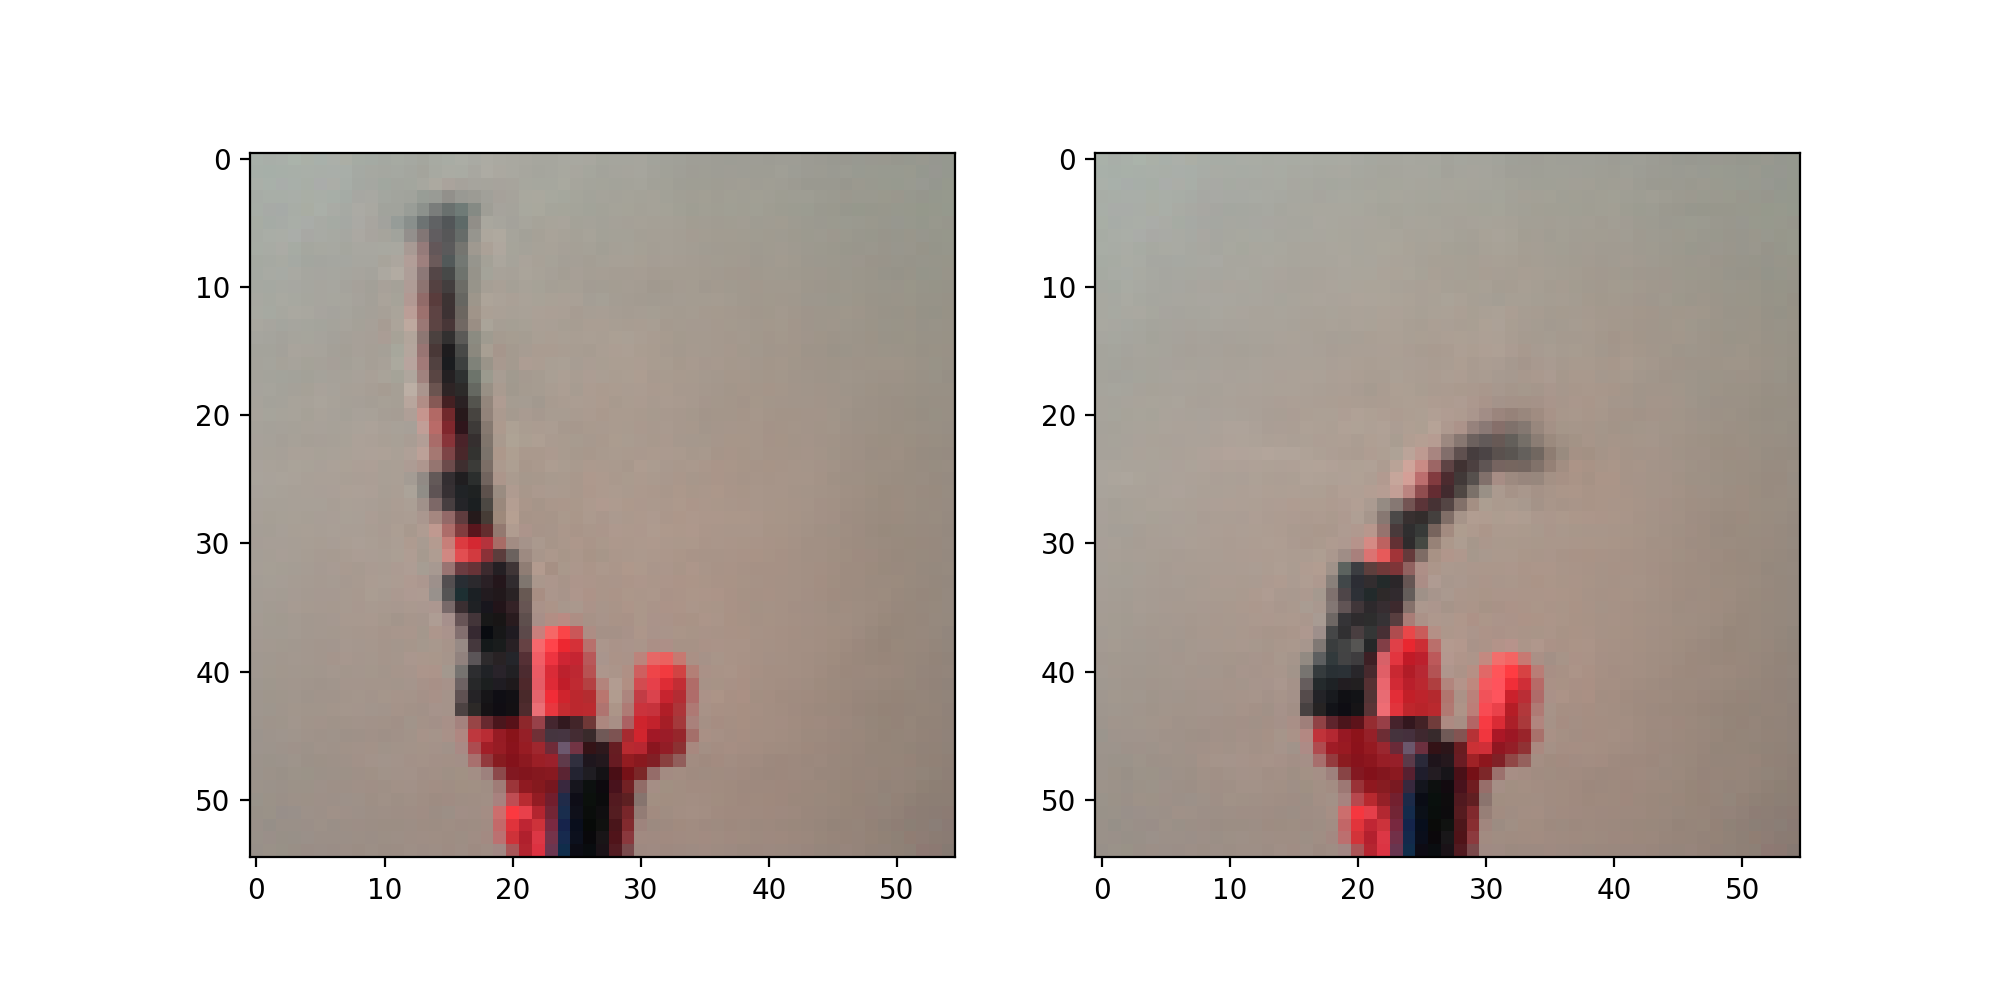

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [30]:
import numpy as np
import time
kidmind.set_noise_level(0)
kidmind.eval()

idx1 = 20
idx2 = 48

batch1 = train_ds.get_samples([idx1])
batch2 = train_ds.get_samples([idx2])

batch1 = kidmind.forward(**batch1)
batch2 = kidmind.forward(**batch2)

img1 = batch1['~s_i'][0,:,:,:].transpose(0,1).transpose(1,2).detach()
img2 = batch2['~s_i'][0,:,:,:].transpose(0,1).transpose(1,2).detach()

p = batch2['p_i']
print(p)

fig = plt.figure(figsize=[10,5])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.imshow(img1.cpu())
ax2.imshow(img2.cpu())

In [22]:
def run_kid_run(start_state, action_sequence, model, clip_val):
    action_sequence = clip_actions(action_sequence, clip_val)
    p_states = list()
    r_states = list()
    s_states = list()
    p_states.append(start_state['p_i'])
    r_states.append(start_state['r_i'])
    s_states.append(start_state['s_i'])
    
    for i in range(len(action_sequence)):
        p_next = kidmind.forward_kinematics_model.forward(p_states[i], action_sequence[i])
        r_next = kidmind.perceptual_model.decode(p_next)
        s_next = kidmind.sensory_model.decode(r_next)
        p_states.append(p_next)
        r_states.append(r_next)
        s_states.append(s_next)
    
    return s_states, r_states, p_states

def calc_loss(target_state, state_sequence, action_sequence):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    mse = torch.nn.MSELoss()
    target_loss = 0
    control_loss = 0
    for i in range(len(action_sequence)):
        control_loss = control_loss + mse(torch.zeros(1,3,device=device), action_sequence[i])
        # target_loss = target_loss + mse(target_state, state_sequence[-1])
    loss = target_loss + 0.1*control_loss/len(action_sequence) + 10*mse(target_state, state_sequence[-1])
    return loss

def clip_actions(actions, clip_val):
    for i in range(len(actions)):
        action = actions[i]
        r = torch.norm(action).detach()
        if r > clip_val:
            action = action / r * clip_val
            actions[i] = action
    return actions

def gen_actions(**kwargs):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    if 'N' in kwargs:
        N = kwargs['N']
        actions = list()
        for i in range(N):
            action = torch.randn(1, 3, requires_grad=True, device=device)
            actions.append(action)
    elif 'actions' in kwargs:
        parent = kwargs['actions']
        actions = list()
        noise_lvl = kwargs['noise_lvl']
        for i in range(len(parent)):
            action = parent[i] + torch.randn(1, 3, requires_grad=True, device=device) * noise_lvl
            action = torch.tensor(action)
            actions.append(action)
    return actions

def calc_fitness(population, start_state, target_state, model, clip_val):
    fitness = np.zeros(len(population))
    for i in range(len(population)):
        action_sequence = population[i]
        s_states, r_states, p_states = run_kid_run(start_state, action_sequence, model, clip_val)
        state_sequence = r_states
        fitness[i] = calc_loss(target_state['r_i'], state_sequence, action_sequence)
    return fitness

def seed_population(**kwargs):
    N = kwargs['N']
    pop_size = kwargs['pop_size']
    population = list()
    for i in range(pop_size):
        population.append(gen_actions(N=N))
    return population

def optimize_seq(actions, start, target, model, steps, learning_rate, clip_val):
    for i in range(len(actions)):
        actions[i] = torch.tensor(actions[i])
    optimizer = torch.optim.Adam(actions, lr=learning_rate)
    for i in range(steps):
        optimizer.zero_grad()
        model.zero_grad()
        s_states, r_states, p_states = run_kid_run(start, actions, model, clip_val)
        loss = calc_loss(target['r_i'], r_states, actions)
        loss.backward(retain_graph=True)
        optimizer.step()
        # print(i, loss, end='\r')
    for i in range(len(actions)):
        actions[i] = torch.tensor(actions[i])
    return actions

def optimize_pop(population, start, target, model, steps, learning_rate, clip_val):
    for i in range(len(population)):
        population[i] = optimize_seq(population[i], start, target, model, steps, learning_rate, clip_val)
    return population

def select_sequences(population, fitness, n_cut, n_children, noise_lvl):
    print(np.min(fitness))
    indices = np.argsort(fitness)
    s_population = list()
    s_fitness = list()
    for i in range(len(indices)):
        s_population.append(population[indices[i]])
        s_fitness.append(fitness[indices[i]])
    s_population = s_population[0:n_cut]
    s_fitness = s_fitness[0:n_cut]
    population = s_population
    for i in range(len(s_population)):
        for j in range(n_children):
            population.append(gen_actions(actions=s_population[i], noise_lvl=noise_lvl))
    return population

def evolve(population, start, target, model, steps, learning_rate, n_cut, n_children, noise_lvl, clip_val, optimize):
    if optimize:
        population = optimize_pop(population, start, target, model, steps, learning_rate, clip_val)
    fitness = calc_fitness(population, start, target, model, clip_val)
    population = select_sequences(population, fitness, n_cut, n_children, noise_lvl)
    return population

In [23]:
start_batch = train_ds.get_samples([idx1])
target_batch = train_ds.get_samples([idx2])

start = kidmind.forward(**start_batch)
target = kidmind.forward(**target_batch)

In [24]:
population = seed_population(N=3, pop_size=100)

In [25]:
steps = 1
learning_rate = 1
n_cut = 10
n_children = 9
noise_lvl = 0.2
clip_val = 0.5
optimize = False

generations = 25
for i in range(generations):
    population = evolve(population, start, target, kidmind, steps, learning_rate, n_cut, n_children, noise_lvl, clip_val, optimize)

0.006594174075871706


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.005128643941134214
0.004001460503786802
0.004001460503786802
0.003209151327610016
0.0027805501595139503
0.0023913446348160505
0.0022478981409221888
0.002176703419536352
0.002176703419536352
0.0014283040072768927
0.0014283040072768927
0.0014283040072768927
0.0014283040072768927
0.0014283040072768927
0.0014283040072768927
0.0014283040072768927
0.0014283040072768927
0.0014283040072768927
0.001314337132498622
0.001314337132498622
0.001314337132498622
0.001314337132498622
0.001314337132498622
0.001314337132498622


<IPython.core.display.Javascript object>


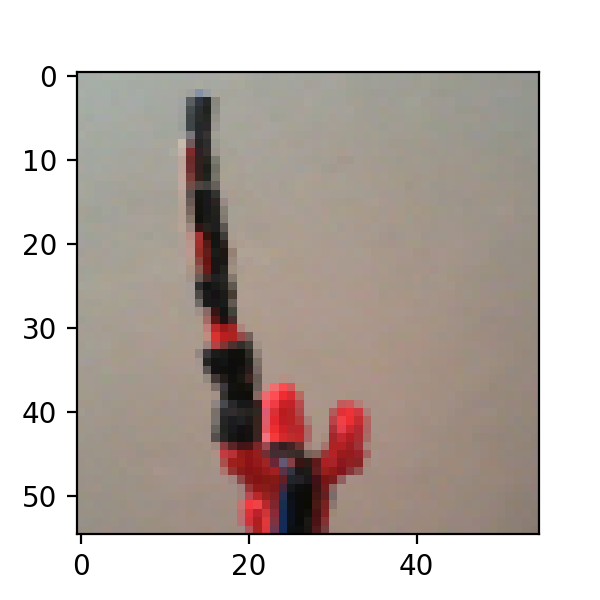

/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


<IPython.core.display.Javascript object>


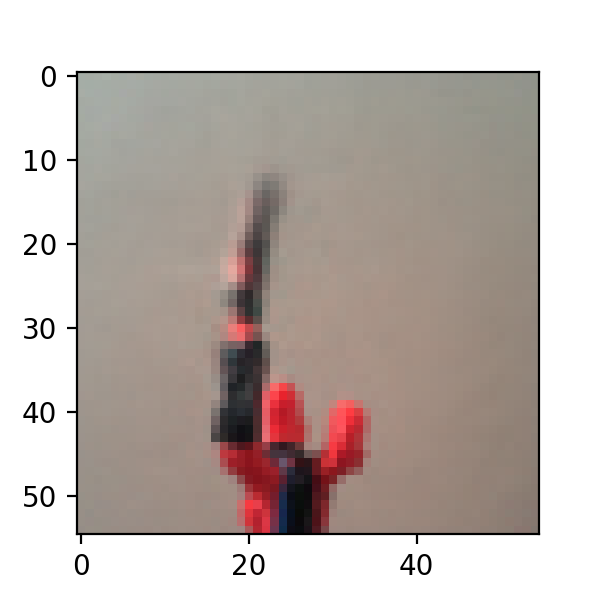

<IPython.core.display.Javascript object>


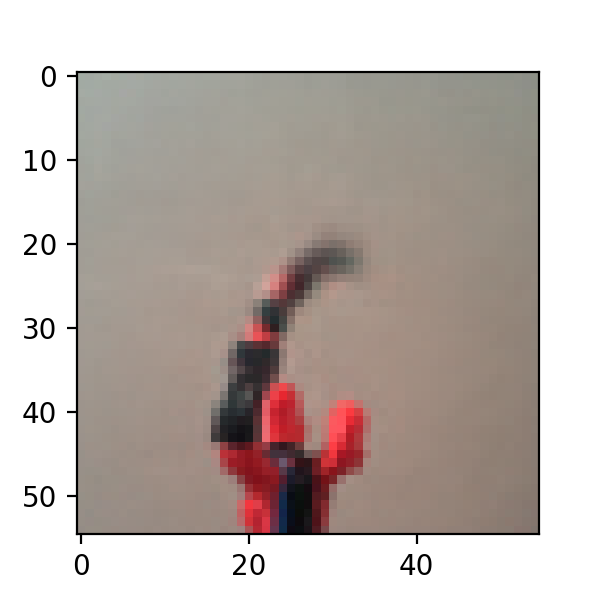

<IPython.core.display.Javascript object>


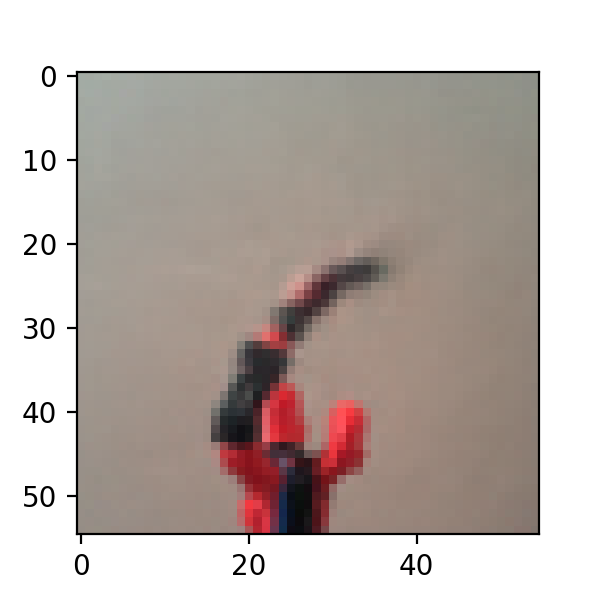

In [28]:
import skimage.io as io

actions = population[0]
s_states, r_states, p_states = run_kid_run(start, actions, kidmind, clip_val)
for i in range(len(s_states)):
    fig = plt.figure(figsize=[3,3])
    img = s_states[i][0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu()
    img[img>1] = 1
    img[img<0] = 0
    io.imsave('/Users/raymondbaranski/Desktop/imgs/' + str(i) + '.png', img)
    plt.imshow(s_states[i][0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu())

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# import matplotlib.pyplot as plt
# import numpy as np

# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.scatter(x[:,0], x[:,1], x[:,2], '.')

In [ ]:
actions

In [ ]:
print(p_states[0])
print(actions[0])
p_next = kidmind.forward_kinematics_model.forward(p_states[0], actions[0])
print('')
print(p_next)
print(p_states[1])
print('')
print(target['r_i'])
print(r_states[-1])

In [ ]:
r_states[1]

In [ ]:
p_states[2]

In [ ]:
print('start: ', p_states[0])
print('action:', actions[0])
p_next = kidmind.forward_kinematics_model.forward(p_states[0], actions[0])
print('')
print(p_next)
for i in range(len(p_states)):
    print(p_states[i])

In [ ]:
import numpy as np
batch = train_ds.get_samples(np.random.permutation(1000))
s_states = batch['s_i']
r_states, pre_r_states = kidmind.sensory_model.encode(s_states)

In [ ]:
data = pre_r_states[:,0].cpu().detach().numpy()
# print(data)
hist = np.histogram(data)

In [ ]:
torch.mean(r_states,0)

In [ ]:
torch.std(r_states,0)

In [ ]:
torch.sqrt(kidmind.sensory_model.bn8.running_var)

In [ ]:
fig = plt.figure()
plt.hist(data, bins=1000)
print(torch.std(torch.tensor(data)))